# How to behave in foreign territory ?
---
### Context
In the paper, "Friendship and mobility : User movement in Location-Based Social Networks", the authors answered one important question : what influence do friends have on movements ?<br>
But what if you don't have friends in the first place and just want to blend in ? Imagine : You just arrived in a new country. You don't know how to behave with the locals and what to expect. How friendly are people ? How often is it socially acceptable to meet ? Where should you meet ? Where and when should you go on holidays ? <br>
In this Notebook, we will attempt to answer some of these questions for multiple countries.

---
### The data
“Global-scale Check-in Dataset with User Social Networks” from two research projects at this address (project 5 by Dingqi Yang): ( https://sites.google.com/site/yangdingqi/home/foursquare-dataset#h.p_7rmPjnwFGIx9). The dataset is coming from Foursquare and it contains the information of 22,809,624 checkins by 114,324 users, 607,333 friendship links and 3,820,891 POIs. It contains a set of worldwide check-ins with country flags taken over about two years and two snapshots of the corresponding user social network before (in Mar. 2012) and after (in May 2014) the check-in data collection period. <br>
In order to work with this dataset, we broke it down in smaller datasets, based on countries. We explain how we did this in steps 1 and 2 of the current notebook.

---
### Structure of this notebook
In the current notebook, we have 5 parts. Click on the name of the part to jump to it.

- [**Step 1 : Our initial dataset is far too big for us to work directly on it. We need to split it**](#Step_1)
    - Substep 1 : Identifying countries/users to exclude and countries/users to keep
    - Substep 2 : Extracting our data to csv files.
- [**Step 2 : Cleaning our data**](#Step_2)
- [**Step 3 : One important way of evaluating social life in a country is by looking at the distance between houses of friends : in a country where friends live close, it should be easier to socialize with new people.**](#Step_3)
    - Substep 1 : Helper functions
    - Substep 2 : Application : we look at the case of the US
    - Substep 3 : We compare results for different countries.
- [**Step 4 : We want to evaluate the sociability of natives. In order to do so, we look at the number of friends that native users have.**](#Step_4)
    - Substep 1 : How to determine if someone is a native or a foreigner ?
    - Substep 2 : Evaluating the number of friends for natives.
- [**Step 5 : We want to behave like a native.**](#Step_5)
    - Substep 1 : We have looked earlier at the most popular places to check-in for native users, what about combinations of places ?
    - Substep 2 : We want to predict the POIs where users check-in in order to understand their behaviours.
        - SubSubStep 1 : The first Checkin of the day
        - SubSubStep 2 : The next Checkins
    
---
### Note :
In the following notebook, all the calculations are done on the US Database, because all of our datasets have the same. When it come to the data story, we will extract information from all datasets.

### Step 1 : Splitting our initial dataset<a id='Step_1'></a>

#### Substep 1 : Identifying countries/users to exclude and countries/users to keep

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import math
import datetime
data_path = '../data.zip/data/'
data_file = ZipFile('../data.zip') 
raw_dataset_file = ZipFile("../dataset_WWW2019.zip")
import warnings
warnings.simplefilter(action='ignore')

In [2]:
# We start by extracting our data from our zip file.
my_df = pd.read_csv(raw_dataset_file.open('dataset_WWW2019/raw_POIs.txt'), header = None, sep = "\t", error_bad_lines=False, names = ["zone_id","Lat","lon","building","country"])
my_df

,zone_id,Lat,lon,building,country
0,3fd66200f964a52000e61ee3,40.729209,-73.998753,Post Office,US
1,3fd66200f964a52000e71ee3,40.733596,-74.003139,Jazz Club,US
2,3fd66200f964a52000e81ee3,40.758102,-73.975734,Gym,US
3,3fd66200f964a52000ea1ee3,40.732456,-74.003755,Indian Restaurant,US
4,3fd66200f964a52000ec1ee3,42.345907,-71.087001,Indian Restaurant,US
...,...,...,...,...,...
11180155,52e92ec0498e1a09484475c9,55.852631,37.447034,Residential Building (Apartment / Condo),RU
11180156,52e92f11498e8e25136e9fe2,-4.329570,-40.711533,Dentist's Office,BR
11180157,52e92f4511d2a77832a49eec,52.505471,13.368507,Financial or Legal Service,DE
11180158,52e92fa5498ef926067570ff,41.025367,28.554854,City,TR


In [3]:
# Since we want to study our data by country, we get the list of all different countries we can study.
list_country = list(my_df.country.unique()) # list of all countries where people have checked in.

# We also create a dataframe where we order each country in accordance to the number of check-ins it holds.
my_countries = my_df.groupby(by = "country").agg("count").sort_values(by = "building", ascending = False).drop(columns = ["zone_id", "Lat", "lon"])
my_countries[my_countries["building"] >=200000]

# We notice that a lot of countries have a few check-ins. We don't know if it's because somebody from another contry
# checked-in once while on holiday or if we have users that check-in occasionely.
# However, since at this stage we just want to get nationality, we surpress countries with too few checkins.

,building
country,
US,1990327
ID,1198611
BR,1159258
TR,1098373
RU,546532
JP,519409
MY,493453
MX,408434
TH,353444


In [4]:
countries_with_large_checkins = my_countries[my_countries["building"] >=20].index.tolist()
countries_to_exclude = [element for element in my_countries.index if element not in countries_with_large_checkins]
print(countries_to_exclude) 

['SX', 'IC', 'SJ', 'SB', 'YT', 'TO', 'FK', 'KI', 'AX', 'NF', 'BV', 'EU', 'MS', 'FM', 'NT', 'MH', 'SH', 'KM', 'TV', 'TF', 'ST', 'UM', 'CS', 'CF', 'NR', 'ER', 'CX', 'PM', 'TA', 'GS', 'BQ', 'WF', 'JT', 'NU', 'FX', 'DD', 'CP']


In [5]:
my_df = my_df[my_df["country"].isin(countries_with_large_checkins)]
my_df
# We notice that removing our countries with a low number of check-ins doesn't change our dataset much.  

,zone_id,Lat,lon,building,country
0,3fd66200f964a52000e61ee3,40.729209,-73.998753,Post Office,US
1,3fd66200f964a52000e71ee3,40.733596,-74.003139,Jazz Club,US
2,3fd66200f964a52000e81ee3,40.758102,-73.975734,Gym,US
3,3fd66200f964a52000ea1ee3,40.732456,-74.003755,Indian Restaurant,US
4,3fd66200f964a52000ec1ee3,42.345907,-71.087001,Indian Restaurant,US
...,...,...,...,...,...
11180155,52e92ec0498e1a09484475c9,55.852631,37.447034,Residential Building (Apartment / Condo),RU
11180156,52e92f11498e8e25136e9fe2,-4.329570,-40.711533,Dentist's Office,BR
11180157,52e92f4511d2a77832a49eec,52.505471,13.368507,Financial or Legal Service,DE
11180158,52e92fa5498ef926067570ff,41.025367,28.554854,City,TR


In [6]:
# As a result, we decide to take drastic measures and to keep only countries with the highest number of checkins.
print(my_countries[my_countries["building"] >=200000])

         building
country          
US        1990327
ID        1198611
BR        1159258
TR        1098373
RU         546532
JP         519409
MY         493453
MX         408434
TH         353444
PH         219097
ES         212161
GB         210777


In [7]:
# We now get our dataset of checkins. This dataset does not contain the name of the country. It however contains
# Indirect information.
### WARNING : running this cell can be very long !
my_df_checkins = pd.read_csv(raw_dataset_file.open('dataset_WWW2019/dataset_WWW_Checkins_anonymized.txt'), header = None, sep = "\t", error_bad_lines=False, names = ["person_id","zone_id","time_checkin","timezone"])
my_df_checkins

,person_id,zone_id,time_checkin,timezone
0,822121,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180
1,208842,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300
2,113817,4b4bade2f964a520cfa326e3,Tue Apr 03 18:00:09 +0000 2012,-240
3,14732,4c143cada5eb76b0dc7dc1b7,Tue Apr 03 18:00:09 +0000 2012,-240
4,1397630,4e88cf4ed22d53877981fdab,Tue Apr 03 18:00:09 +0000 2012,-300
...,...,...,...,...
22809619,1568872,502bb1cee4b0190fdc74767b,Wed Jan 29 16:43:46 +0000 2014,420
22809620,689856,4d701b20b73bb1f70867b472,Wed Jan 29 16:43:56 +0000 2014,-180
22809621,567861,4b51b5ecf964a5203e5327e3,Wed Jan 29 16:44:04 +0000 2014,-120
22809622,44698,504a21c3e4b0568d3c5e6794,Wed Jan 29 16:44:16 +0000 2014,-360


In [8]:
# Our participants checked-in at least 73 times in foursquare. As a result, we don't have to exclude any user from
# our dataset.
my_participants = my_df_checkins.groupby(by = "person_id").agg("count")
my_participants.min()

zone_id         73
time_checkin    73
timezone        73
dtype: int64

#### Substep 2 Extracting csv files from our initial dataset.

In [9]:
def extract_year(country_code, my_year, Checkin_dataframe, POI_dataframe, timezone_low, timezone_high = None):
    ### Function to extract a dataframe for a given country in a given year. The returned dataframe is of the form : 
    ###  index = zone_id	person_id 	time_checkin 	year 	Lat 	lon 	building 	country
    ### time_checkin and year are of type pandas._libs.tslibs.timestamps.Timestamp
    ### In order to extract one country, you have to give "country_code" (ex : "US"), "my_year" (a str ex : "2013")
    ### The dataframe of all checkins, the dataframe of all POI and the timezone of the country in minutes
    ### (ex : for the US, the timezone is timezone_low = -480, timezone_high = -300. If you have only one timezone
    ### like GB who only has timezone_low = 0, don't give an argument for timezone_high).
    ### We have to look on the internet to find the timezone.
    
    ### IMPORTANT : the time complexity of this function is very much linked to the number of timezones in a country. 
    
    timezone_low *= 60    
    if timezone_high is None:
        timezone_high = timezone_low + 1
    else:
        timezone_high *= 60

        
    # We focus only on one country, we extract all the POI of this country.
    country_POI = POI_dataframe[POI_dataframe["country"] == country_code]
    
    # We think it could be a bit long to merge our two datasets on 22 million entries. As a result, we do a first
    # verification : a user in a given country if he doesn't match the timezone of the country.
    Checkins_in_timezone = Checkin_dataframe[Checkin_dataframe.timezone.between(timezone_low, timezone_high)].drop("timezone", axis = 1)
    
    # We extract the year we are interested in.
    Checkins_in_timezone["time_checkin"] = pd.to_datetime(Checkins_in_timezone["time_checkin"], format = "%a %b %d %X %z %Y",errors='coerce')
    Checkins_in_timezone["year"] = pd.DatetimeIndex(Checkins_in_timezone["time_checkin"]).year
    Checkins_in_year = Checkins_in_timezone[Checkins_in_timezone["year"] == pd.to_datetime(my_year).year]
    
    # Finally, we merge our datasets.
    merge_checkins = pd.merge(Checkins_in_year.set_index("zone_id"), country_POI.set_index("zone_id"), left_index=True, right_index=True)
    return(merge_checkins)

We extract the 10 countries with the most buildings in the dataframe "my_country". Since our data for 2012 and 2014 don't cover the full year, we only extract data from 2013.

In [12]:
### WARNING ! THIS CELL IS EXTREMELY LONG TO RUN ! Don't run it if you don't need to !
### FOR SAFETY PURPOSES, we have commented all the code inside. Uncomment if you want to run.

#US1_db = extract_year("US", "2013", my_df_checkins, my_df, -11,-4) #USA
#ID2_db = extract_year("ID", "2013", my_df_checkins, my_df, 7,9) #Indonesia
#BR3_db = extract_year("BR", "2013", my_df_checkins, my_df, -5,-2) #Brazil
#TR4_db = extract_year("TR", "2013", my_df_checkins, my_df, 3) #Turkey
#RU5_db = extract_year("RU", "2013", my_df_checkins, my_df, 2,12) #Russia
#JP6_db = extract_year("JP", "2013", my_df_checkins, my_df, 9) #Japan
#MY7_db = extract_year("MY", "2013", my_df_checkins, my_df, 8) #Malaysia
#MX8_db = extract_year("MX", "2013", my_df_checkins, my_df, -8,-5) #Mexico
#TH9_db = extract_year("TH", "2013", my_df_checkins, my_df, 7) #Thailand
#PH10_db = extract_year("PH", "2013", my_df_checkins, my_df, 8) #Philippines

In [13]:
# We then store the dataframes in csv files so that we can access them without having to load the bigger datasets.

#US1_db.to_csv("1_US_2013_merge_data.csv", index = True)
#ID2_db.to_csv("2_ID_2013_merge_data.csv", index = True)
#BR3_db.to_csv("3_BR_2013_merge_data.csv", index = True)
#TR4_db.to_csv("4_TR_2013_merge_data.csv", index = True)
#RU5_db.to_csv("5_RU_2013_merge_data.csv", index = True)
#JP6_db.to_csv("6_JP_2013_merge_data.csv", index = True)
#MY7_db.to_csv("7_MY_2013_merge_data.csv", index = True)
#MX8_db.to_csv("8_MX_2013_merge_data.csv", index = True)
#TH9_db.to_csv("9_TH_2013_merge_data.csv", index = True)
#PH10_db.to_csv("10_PH_2013_merge_data.csv", index = True)

A first interesting fact is that we have more data in 2012 than any other year. This is surprising since we don't even have the data for a full year !<br>
We have less data in 2013 though we have the full year data. This can be explained by the fact that foursquare's popularity was starting to waver and would only grow again towards 2014 with the release of "swarm", a companion app to foursquare. <br>
In order to have a coherent dataset, we will start by working on data from 2013 (where we have the full year) and check our results by using data from 2012 and 2014.

### Step 2 : Cleaning our data<a id='Step_2'></a>

We check quickly that all our values are legal (no latitudes bigger than 90 our longitude bigger than 180). <br>
We notice that all points are in the correct interval, which is a blessing :)

In [14]:
ID_df = pd.read_csv(data_file.open('data/2_ID_2013_merge_data.csv'))
ID_df

,zone_id,person_id,time_checkin,year,Lat,lon,building,country
0,4b05880ff964a5201caf22e3,1170327,2013-01-02 06:04:37+00:00,2013,1.145077,104.010916,Other Great Outdoors,ID
1,4b05880ff964a5201caf22e3,1170327,2013-01-11 11:31:56+00:00,2013,1.145077,104.010916,Other Great Outdoors,ID
2,4b05880ff964a5201caf22e3,1170327,2013-01-15 10:18:07+00:00,2013,1.145077,104.010916,Other Great Outdoors,ID
3,4b05880ff964a5201caf22e3,408433,2013-01-30 11:12:24+00:00,2013,1.145077,104.010916,Other Great Outdoors,ID
4,4b05880ff964a5201caf22e3,408433,2013-01-30 11:25:09+00:00,2013,1.145077,104.010916,Other Great Outdoors,ID
...,...,...,...,...,...,...,...,...
771866,52b6c7f611d255fa1a7392a3,707704,2013-12-22 11:08:20+00:00,2013,0.475714,121.241539,Rest Area,ID
771867,52b6ca4e498e15b460e38ab2,683822,2013-12-22 11:17:49+00:00,2013,-6.227489,106.825379,Australian Restaurant,ID
771868,52b6cada11d248b7b56d2374,1264982,2013-12-22 11:20:12+00:00,2013,-8.569188,114.090425,Home (private),ID
771869,52b6cd3e498ea6b8c72aa057,1499509,2013-12-22 11:46:16+00:00,2013,1.459921,124.823780,Home (private),ID


In [15]:
#Helpers
def dropLocationId(df):
    return df.drop(['zone_id'],axis=1)

def dropCheckinTime(df):
    return df.drop(['time_checkin'],axis=1)

def dropMissingLatOrLng(df):
    return df[~((df['Lat'] == 0) | (df['lon'] == 0))]

def dropInvalidLat(df):
    return df[(df['Lat'] < 90) & (df['Lat'] > -90)]

def dropInvalidLng(df):
    return df[(df['lon'] < 180) & (df['lon'] > -180)]

def preprocess(df):
    df_ = df.copy()
    #drop Rows having NaN/Null/NaT Values 
    df_ = df_.dropna(how="any")

    #drop Rows having invalid Values 
    df_ = dropMissingLatOrLng(df_)

    df_ = dropInvalidLat(df_)
    df_ = dropInvalidLng(df_)
    return df_
    

In [16]:
totalChekinsBefore = ID_df.shape[0]
clean_df = preprocess(ID_df)
#Total number of check-ins 
print('Before the preprocessing, the dataset had : '+ str(totalChekinsBefore) + ' checkins')
print('After the preprocessing, the dataset had : '+ str(clean_df.shape[0]) + ' checkins')

Before the preprocessing, the dataset had : 771871 checkins
After the preprocessing, the dataset had : 771871 checkins


### Step 3 : Studying friendships <a id='Step_3'></a>

#### Substep 1 : Helper functions

In [17]:
# Helper function which finds the distance between two points from their latitude and longitude coordinates
# They are used later.

def find_distance(lat1, lat2, lon1, lon2):
    ### This fonction takes four columns of a dataframe and returns the column with all the distances
    ### calculated point by point.
    earth_radius = 6373 # In km
    lat1 = lat1/180 * math.pi
    lat2 = lat2/180 * math.pi
    dlat = lat2 - lat1
    dlon = (lon1 - lon2)/180 * math.pi
    a = (dlat/2).apply(math.sin)**2 + lat1.apply(math.cos) * lat2.apply(math.cos) * (dlon/2).apply(math.sin)**2
    c = 2 * (a.apply(math.sqrt) / (1 - a).apply(math.sqrt)).apply(math.atan)
    d = earth_radius * c
    distance_db = pd.DataFrame(d).rename(columns = {0 : 'distance'})
    return(distance_db)


# For each user, we want to assign them to one square (the one in which they checked-in the most).*
# In order to do so, we create a column named "my_square" which gives the name of the square in which each column
# is in. We take latitude = 0 and longitude = 0 to be the centre of the origin square.
# The names of our 25km * 25km squares are chosen as the tuple (latitude, longitude)
# In order to make our code more compact we create a function to create our labeling of squares.

def square_label(my_dataframe):
    inter = pd.DataFrame()
    cos_latitude = (my_dataframe['latitude']/180 * math.pi).apply(math.cos)
    inter["rounded_latitude"] = (110.574 * (my_dataframe['latitude'])/25).apply(round)
    inter["rounded_longitude"] = (111.320 * cos_latitude* (my_dataframe['longitude'])/25).apply(round)
    inter_list = inter.values.tolist()
    my_dataframe['my_square'] = [tuple(val) for val in inter_list]
    return(my_dataframe)


# For each user, we get the number of times where they checked in in a given location. We associate the position
# of their home with the position of the location where they checked in the most.
# In case of a draw (a user checked in the same number of times in two locations), we average the position of the
# house over the position of the most checked in locations.

def find_homes_avg(dataframe):
    grouped_data = dataframe.groupby(["user", "my_square"]).count()
    grouped_data = grouped_data.reset_index().drop(columns = ["locid"])
    # We start by getting all the values where there was a draw. (Takes a few minutes)
    # We then extract just the columns "user" and "my_square" to work on them.
    draw_data = grouped_data.groupby("user").apply(lambda x: x.loc[x["time"] == x["time"].max()])
    draw_value = pd.DataFrame(draw_data[["user", "my_square"]].values).rename(columns = {0 : 'user', 1 : 'my_square'})
    return(draw_value)


# Once we have filtered our home data, we can do our average over the right "my_square"

def compute_house_position(dataframe, home_data):
    dataframe = dataframe.merge(home_data, how = "inner", left_on = ["user", "my_square"], right_on = ["user", "my_square"])
    return(dataframe.groupby("user")[["latitude", "longitude"]].mean())


# At first, we think of doing a left join between our edge dataset and our house position dataframe. 
# We however realize that some users never checked in and therefore have no addresses.
# As a result, we decide to do an inner join.

def join_homes_and_user(dataframe, home_data):
    first_join = dataframe.merge(home_data, left_on = "friend", right_on = "user").rename(columns = {"latitude" : "friend latitude", "longitude" : "friend longitude"})
    second_join = first_join.merge(home_data, left_on = "pal", right_on = "user").rename(columns = {"latitude" : "pal latitude", "longitude" : "pal longitude"})
    return(second_join)

#### Substep 2 : loading the data and extracting results

In [18]:
# We start by loading the data. We also change the type of the values that we are going to use.

#US_checkins = pd.read_csv(data_path+'1_US_2013_merge_data.csv', names=['locid','user', 'time','year',  'latitude', 'longitude', 'building', 'countries'],header=None, error_bad_lines=False)
# uncomment the next line only if you are Clement
US_checkins = pd.read_csv(data_file.open('data/1_US_2013_merge_data.csv'), names=['locid','user', 'time','year',  'latitude', 'longitude', 'building', 'countries'],header=None, error_bad_lines=False)
US_checkins.drop(0,0,inplace=True)
US_checkins.user = US_checkins.user.astype(int)
US_checkins.latitude = US_checkins.latitude.astype(float)
US_checkins.longitude = US_checkins.longitude.astype(float)

# Now that our data have the shape that we want, we add the column "my_square" indicating the 25*25 km square in 
# which our checkin is
US_checkins = square_label(US_checkins)
US_checkins.head(10)

,locid,user,time,year,latitude,longitude,building,countries,my_square
1,3fd66200f964a52000e71ee3,319827,2013-01-13 00:49:25+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
2,3fd66200f964a52000e71ee3,496140,2013-01-13 01:12:49+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
3,3fd66200f964a52000e71ee3,288077,2013-02-16 02:29:11+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
4,3fd66200f964a52000e71ee3,191931,2013-02-17 03:50:53+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
5,3fd66200f964a52000e71ee3,1402791,2013-02-19 03:48:11+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
6,3fd66200f964a52000e71ee3,80590,2013-03-15 01:25:06+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
7,3fd66200f964a52000e71ee3,1967638,2013-03-17 00:29:22+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
8,3fd66200f964a52000e71ee3,952766,2013-03-17 05:18:40+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
9,3fd66200f964a52000e71ee3,651362,2013-05-08 04:02:48+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
10,3fd66200f964a52000e71ee3,100462,2013-05-12 02:31:32+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"


In [19]:
#df_friend = pd.read_csv('dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
df_friend = pd.read_csv(raw_dataset_file.open('dataset_WWW2019/dataset_WWW_friendship_new.txt'), header = None, sep = "\t", names = ["friend", "pal"])
df_friend

,friend,pal
0,15,595326
1,19,54
2,19,1061
3,19,1668
4,19,21596
...,...,...
607328,2166684,2181580
607329,2167183,2175735
607330,2170360,2174239
607331,2173716,2186144


In [20]:
# We now use the helper functions to extract the position of each user.

home_data_avg = find_homes_avg(US_checkins)
home_positions_avg = compute_house_position(US_checkins, home_data_avg)
home_positions_avg

,latitude,longitude
user,,
19,40.723447,-73.988018
39,40.797902,-73.604889
54,37.766274,-122.430362
58,40.691485,-73.985955
78,40.758735,-73.901430
...,...,...
2173091,38.918054,-77.222156
2174127,38.971024,-94.705508
2174989,26.137223,-80.108706


In [21]:
# We now merge our different datasets in a big dataset from which we can get distances between friends' houses.
home_positions_avg = home_positions_avg.reset_index()
df_friend.merge(home_positions_avg, left_on = "friend", right_on = "user").merge(home_positions_avg, left_on = "pal", right_on = "user")
friend_home_df_avg = join_homes_and_user(df_friend, home_positions_avg)
friend_home_df_avg

,friend,pal,user_x,friend latitude,friend longitude,user_y,pal latitude,pal longitude
0,19,54,19,40.723447,-73.988018,54,37.766274,-122.430362
1,19,1061,19,40.723447,-73.988018,1061,37.749693,-122.444928
2,866,1061,866,21.305919,-157.857979,1061,37.749693,-122.444928
3,19,1668,19,40.723447,-73.988018,1668,40.725943,-73.993047
4,54,1668,54,37.766274,-122.430362,1668,40.725943,-73.993047
...,...,...,...,...,...,...,...,...
58230,2073933,2149533,2073933,33.961452,-118.427382,2149533,33.996001,-118.431961
58231,2076284,2095717,2076284,38.865423,-104.770159,2095717,38.892645,-104.775632
58232,2076284,2098263,2076284,38.865423,-104.770159,2098263,40.552342,-105.061401
58233,2095717,2098263,2095717,38.892645,-104.775632,2098263,40.552342,-105.061401


In [22]:
# We now get the dataframe of distances that we can plot.
distance_db_avg = find_distance(friend_home_df_avg["friend latitude"], friend_home_df_avg["pal latitude"], friend_home_df_avg["friend longitude"], friend_home_df_avg["pal longitude"])

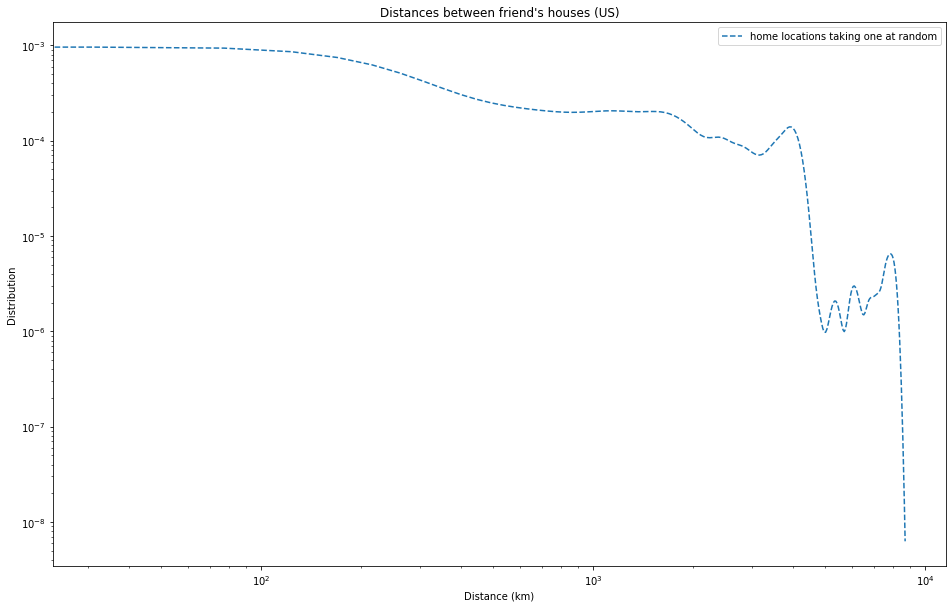

In [23]:
# We use the seaborn kdeplot to have a distribution. We notice that our distribution plot is very similar to the
# one we obtained with the datasets from Gowalla and Brightkite. This result intuitively makes sense, since we
# work on the same country. The only different parameter is the year of study (and it shouldn't impact much our
# results, people don't move a lot overall).

fig, ax = plt.subplots(figsize = (16, 10))
sns.kdeplot(distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'home locations taking one at random')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.title("Distances between friend's houses (US)")
plt.ylabel("Distribution")
plt.xlabel("Distance (km)")
ax.legend()
plt.show()

#### Substep 3 : We now look at results using datasets from different countries

In [24]:
# We create a routine to open a dataframe and to compute all the distances between friends' houses. In order to do
# so, we use the helper functions coded above.

def distance_db_avg(df_friend, dataframe):
    # loading the data
    #checkins = pd.read_csv(data_path+dataframe, names=['locid','user', 'time','year',  'latitude', 'longitude', 'building', 'countries'],header=None, error_bad_lines=False)
    # Uncomment the following line only if you are Clement
    checkins = pd.read_csv(data_file.open('data/'+dataframe), names=['locid','user', 'time','year',  'latitude', 'longitude', 'building', 'countries'],header=None, error_bad_lines=False)
    
    # convert string to number
    checkins.drop(0,0,inplace=True)
    checkins.user = checkins.user.astype(int)
    checkins.latitude = checkins.latitude.astype(float)
    checkins.longitude = checkins.longitude.astype(float)
    
    # Extracting useful informations (House location)
    checkins = square_label(checkins)
    home_data_avg = find_homes_avg(checkins)
    home_positions_avg = compute_house_position(checkins, home_data_avg)
    home_positions_avg = home_positions_avg.reset_index()
    
    # merge on the friend dataframe
    df_friend.merge(home_positions_avg, left_on = "friend", right_on = "user").merge(home_positions_avg, left_on = "pal", right_on = "user")
    friend_home_df_avg = join_homes_and_user(df_friend, home_positions_avg)
    distance_db_avg = find_distance(friend_home_df_avg["friend latitude"], friend_home_df_avg["pal latitude"], friend_home_df_avg["friend longitude"], friend_home_df_avg["pal longitude"])
    return distance_db_avg

In [25]:
#df_friend = pd.read_csv(data_path+'dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
df_friend = pd.read_csv(raw_dataset_file.open('dataset_WWW2019/dataset_WWW_friendship_new.txt'), header = None, sep = "\t", names = ["friend", "pal"])
US_distance_db_avg  = distance_db_avg(df_friend, '1_US_2013_merge_data.csv')
PH_distance_db_avg  = distance_db_avg(df_friend, '10_PH_2013_merge_data.csv')
ID_distance_db_avg  = distance_db_avg(df_friend, '2_ID_2013_merge_data.csv')
#BR_distance_db_avg  = distance_db_avg(df_friend, '3_BR_2013_merge_data.csv')
TR_distance_db_avg  = distance_db_avg(df_friend, '4_TR_2013_merge_data.csv')
RU_distance_db_avg  = distance_db_avg(df_friend, '5_RU_2013_merge_data.csv')
JP_distance_db_avg  = distance_db_avg(df_friend, '6_JP_2013_merge_data.csv')
MY_distance_db_avg  = distance_db_avg(df_friend, '7_MY_2013_merge_data.csv')
MX_distance_db_avg  = distance_db_avg(df_friend, '8_MX_2013_merge_data.csv')
TH_distance_db_avg  = distance_db_avg(df_friend, '9_TH_2013_merge_data.csv')

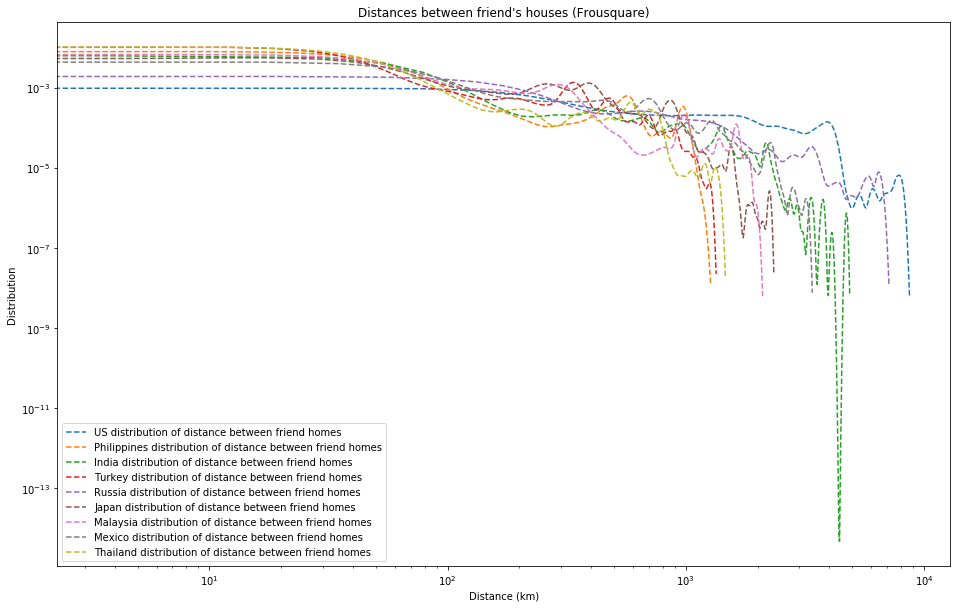

In [26]:
# We compare the distance between houses with our multiple dataframes of houses locations.

fig, ax = plt.subplots(figsize = (16, 10))
sns.kdeplot(US_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'US distribution of distance between friend homes')
sns.kdeplot(PH_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'Philippines distribution of distance between friend homes')
sns.kdeplot(ID_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'India distribution of distance between friend homes')
#sns.kdeplot(BR_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'Brazil distributioon of distance between friend homes')
sns.kdeplot(TR_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'Turkey distribution of distance between friend homes')
sns.kdeplot(RU_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'Russia distribution of distance between friend homes')
sns.kdeplot(JP_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'Japan distribution of distance between friend homes')
sns.kdeplot(MY_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'Malaysia distribution of distance between friend homes')
sns.kdeplot(MX_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'Mexico distribution of distance between friend homes')
sns.kdeplot(TH_distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'Thailand distribution of distance between friend homes')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.title("Distances between friend's houses (Frousquare)")
plt.ylabel("Distribution")
plt.xlabel("Distance (km)")
ax.legend()
plt.show()

### Conclusion
When comparing the distribution of distances between friends' houses, we notice that the countries with the smallest surfaces are the ones where the probabilities of having friends living far away is the lowest. Indeed, for example, for Turkey, there are no friends living at a distance bigger than 10^3. When we look at the distance between Turkish cities (https://distancecalculator.globefeed.com/Turkey_Distance_Calculator.asp), we notice that most of them are smaller than 10^3. We observe similar results for other countries.

In order to check what we just saw, we look at the 80% quantile for the distance between the houses of two friends living in the same country. If users have friends that live far apart, we guess that can influence our distribution of distribution. Keeping ties with people living far apart can also be an indicator of sociability.<br>
In the cell below, we find the quantiles. What we find confirms the result on the distribution. It is also the occasion to state some advise : If you live in Thailand and want to make friends with someone, move close to him !

In [27]:
print("Most friends in the US live within distance of {} km".format(US_distance_db_avg["distance"].quantile(q = 0.8)))
print("Most friends in Philippines live within distance of {} km".format(PH_distance_db_avg["distance"].quantile(q = 0.8)))
print("Most friends in India live within distance of {} km".format(ID_distance_db_avg["distance"].quantile(q = 0.8)))
#print("Most friends in US live within distance of in Brazil {} km".format(BR_distance_db_avg["distance"].quantile(q = 0.9)))
print("Most friends in Turkey live within distance of {} km".format(TR_distance_db_avg["distance"].quantile(q = 0.8)))
print("Most friends in Russia live within distance of {} km".format(RU_distance_db_avg["distance"].quantile(q = 0.8)))
print("Most friends in Japan live within distance of {} km".format(JP_distance_db_avg["distance"].quantile(q = 0.8)))
print("Most friends in Malaysia live within distance {} km".format(MY_distance_db_avg["distance"].quantile(q = 0.8)))
print("Most friends in Thailand live within distance {} km".format(TH_distance_db_avg["distance"].quantile(q = 0.8)))
print("Most friends in Mexico live within distance {} km".format(MX_distance_db_avg["distance"].quantile(q = 0.8)))

Most friends in the US live within distance of 2425.278974631996 km
Most friends in Philippines live within distance of 109.67993262884694 km
Most friends in India live within distance of 117.49345261424226 km
Most friends in Turkey live within distance of 312.7170752245104 km
Most friends in Russia live within distance of 639.7191102549908 km
Most friends in Japan live within distance of 399.69973966713496 km
Most friends in Malaysia live within distance 270.3267611776484 km
Most friends in Thailand live within distance 63.96111454484407 km
Most friends in Mexico live within distance 482.3843000344747 km


### Step 4 : Natives and foreigners<a id='Step_4'></a>

We want to measure how sociable natives are. In order to do so, we look at how many friends they have.

#### Subpart 1 : Finding nationalities
---

We open a dataset (example : the check-ins that took place in the US in 2013). However, we don't know if all the people of this dataset are American or foreigner on vacation. Since we want to study the behaviour of the locals, we need a criterion to distinguish natives from foreigners.
- Idea 1 : We choose that a person is considered a native if he checks in more than five times in the country.
- Idea 2 : A person is considered a foreigner if he never checks in a home.

In [2]:
data_file = ZipFile('../data.zip')
df_US = pd.read_csv(data_file.open('data/1_US_2013_merge_data.csv'))
US_participants = df_US.groupby(by = "person_id").agg("count")
US_natives =  US_participants[US_participants["zone_id"] >= 5]
US_foreign = US_participants[US_participants["zone_id"] < 5]
US_natives["zone_id"]

person_id
19         146
54          40
58          73
120         56
178         91
          ... 
2169607      5
2169991     27
2174127     92
2174989      6
2181131    116
Name: zone_id, Length: 16987, dtype: int64

In [3]:
df_US_foreign = df_US[df_US["person_id"].isin(US_foreign.index.tolist())]
df_US_natives = df_US[df_US["person_id"].isin(US_natives.index.tolist())]
print('Our initial dataset had {} users.'.format(US_participants.shape[0]))
print('Out of them, {} are considered natives.'.format(US_natives.shape[0]))
print('Out of all our users, {}% have low checkins.'.format(round((1-US_natives.shape[0]/US_participants.shape[0])*100)))

Our initial dataset had 20495 users.
Out of them, 16987 are considered natives.
Out of all our users, 17% have low checkins.


Getting rid of users can seem a bit dangerous because we lose data. However, since we get rid of users with a low number of Checkins, there isn't too much loss. Furthermore, we can associate low checkin users to visitors and get an approximation of the number of visitors as showed in last cell.

In order to do a sanity check, we look at the most popular POIs for natives and we compare them to the most popular POIs for people classified as foreigners.

<BarContainer object of 20 artists>

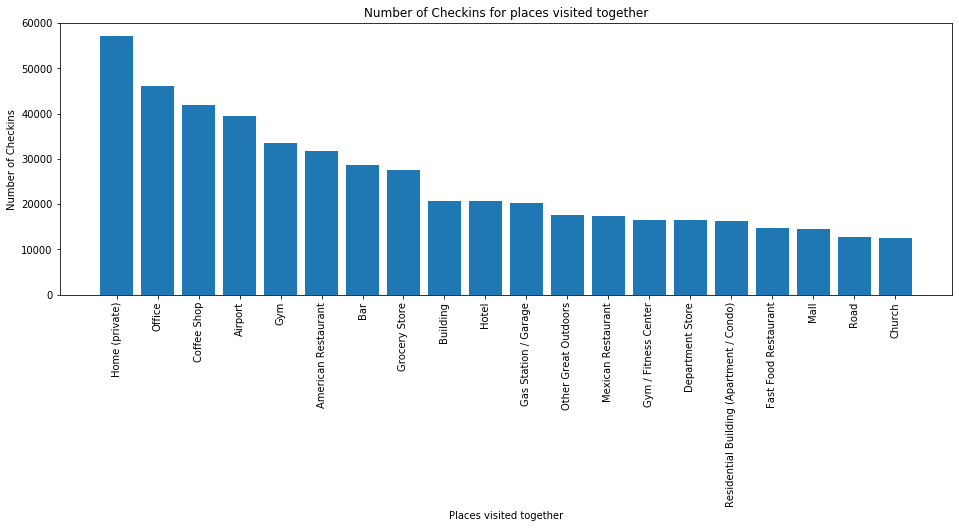

In [4]:
popular_places = df_US_natives.groupby(by = "building").agg("count").sort_values(by = "person_id", ascending = False)

fig, ax = plt.subplots(figsize=(16,5))

plt.title('Number of Checkins for places visited together')
plt.ylabel('Number of Checkins')
plt.xlabel('Places visited together')
plt.xticks(rotation=90)

my_index = [str(element) for element in popular_places.head(20).index]
my_values = [element[0] for element in popular_places.head(20).values]
plt.bar(my_index, my_values)

**Interpretation**: Unsurprinsingly, most people check-in at their home and on the workplace (places where they go the most). The fact that hole locations are the most popular chckin place justifies our approach for assigning house locations to users. We also notice that they check-in a lot in Coffee Shops (which we can interpret as "they check-in during break time"). For Airports, we can interpret it as traveling for work (or going from one coast to another) or leisure. When it comes to food, the two most popular restaurants to go to are American and Mexican restaurants (Fast-food being the third one). This may come from the fact that these three types of restaurants are the most represented in the country. <br>
We notice that if we increase the threshold from "We choose that a person is considered a native if he checks in more than five times in the country" to "We choose that a person is considered a native if he checks in more than ten times in the country", our most popular places stay the same for natives and foreigners.

<BarContainer object of 20 artists>

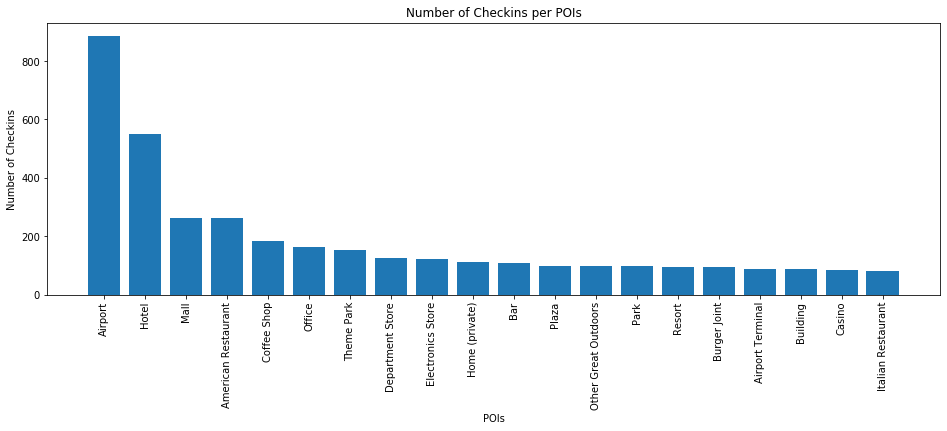

In [5]:
popular_places_foreign = df_US_foreign.groupby(by = "building").agg("count").sort_values(by = "person_id", ascending = False)

fig, ax = plt.subplots(figsize=(16,5))

plt.title('Number of Checkins per POIs')
plt.ylabel('Number of Checkins')
plt.xlabel('POIs')
plt.xticks(rotation=90)

my_index = [str(element) for element in popular_places_foreign.head(20).index]
my_values = [element[0] for element in popular_places_foreign.head(20).values]
plt.bar(my_index, my_values)

**Interpretation**: We look back at the people we classified as foreigners and want to see where they checked-in in order to verify our assumptions. We see that they checked mainly in Hotels, Airports, Malls, Restaurants and Coffee Shops which are destinations that any tourist would go to. However, since we have much less data then last part, we can suspect that these popular places may know high variance. <br>
We however notice that a lot of users who are classified as foreigners check-in at a home. While this can be considered as them checking in a friend or them just going to a zone_id with many houses, we want to investigate. We try a second model, where we classify as foreigner people who never check-in in a Home.

In [31]:
list_of_people_with_homes = df_US[df_US["building"] == "Home (private)"].person_id.unique().tolist()
df_US_natives_2 = df_US[df_US["person_id"].isin(list_of_people_with_homes)]
print('Our initial dataset had {} users.'.format(US_participants.shape[0]))
print('Out of them, {} are considered natives.'.format(len(df_US_natives_2.person_id.unique().tolist())))

Our initial dataset had 20495 users.
Out of them, 5364 are considered natives.


We notice that when we keep only users with a Home, the number of users falls drastically. We therefore think that going to a home is not an interesting criterion for determining if a user is a native.<br>
Furthermore, for countries other than the US, checking-in in a home is an unusual thing to do. We will see it below with the example of Japan.

We now sum up everything that we have done in Step 2 so far in a python function. In order that our functions translate to other datasets, we check our results with the dataset of japanese logins.

In [6]:
def get_natives(dataframe):
    # We start by removing all users with low checkins, they are classified as foreigner and therefore don't
    # give us a clear view of how to behave like the natives.
    all_participants = dataframe.groupby(by = "person_id").agg("count")
    df_person_natives =  all_participants[all_participants["zone_id"] >= 5]
    df_natives = dataframe[dataframe["person_id"].isin(df_person_natives.index.tolist())]
    return(df_natives)

<BarContainer object of 20 artists>

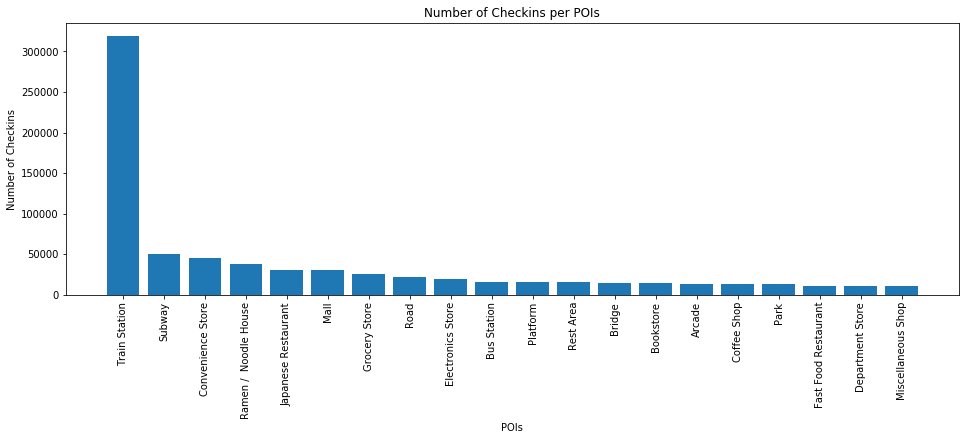

In [7]:
df_JP = pd.read_csv(data_file.open('data/6_JP_2013_merge_data.csv'))
natives_JP = get_natives(df_JP)
popular_places = natives_JP.groupby(by = "building").agg("count").sort_values(by = "person_id", ascending = False)

fig, ax = plt.subplots(figsize=(16,5))

plt.title('Number of Checkins per POIs')
plt.ylabel('Number of Checkins')
plt.xlabel('POIs')
plt.xticks(rotation=90)

my_index = [str(element) for element in popular_places.head(20).index]
my_values = [element[0] for element in popular_places.head(20).values]
plt.bar(my_index, my_values)

We notice that "Home (private)" doesn't appear in the top 10 POIs for Japan. <br>
We notice that an overwhelming amount of checkins are made in train stations. This is due to the fact that the Shinkansen (bullet train) is very popular (https://en.wikipedia.org/wiki/Transport_in_Japan) and that owning a car is not something as common as in the US. We notice that the most popular places to eat are "Ramen/noodle house" and "Japanese Retaurant" which makes sense intuitively. We notice also the appearance of typical japanese places like the arcade (who died too soon in all countries except Japan. RIP sweet arcades, we won't forget you).<br>
A problem that appears with our data is that when we compute house locations, we look at the place with the biggest number of check-ins. In the case of Japan, that might be the position of the nearest train station from home and not of the real home position.

#### Substep 2 : Number of friends of natives
---

Now that we have our native users, we want to see how many friends they have. This can serve as an index of how social are the people of the country. In order to have more precise, we compute a 90% confidence interval.

In [34]:
nb_friends = []
for i in range(20):
    sample_abb = US_foreign.sample(frac = 0.8, random_state = i)
    df_friend = df_friend[df_friend.friend.isin(sample_abb.index.tolist())]
    nb_friends.append(df_friend.shape[0]/len(df_friend.friend.unique()))
nb_friends.sort()

In [35]:
print("Natives have on average {} friends, our 90% confidence interval is[ {}, {}]".format(np.average(nb_friends), nb_friends[1], nb_friends[-2]))

Natives have on average 6.263280768106974 friends, our 90% confidence interval is[ 4.91578947368421, 7.822822822822823]


We have an average, however, we don't even know if it is relevant or not. In order to do so, we look at our quartiles.

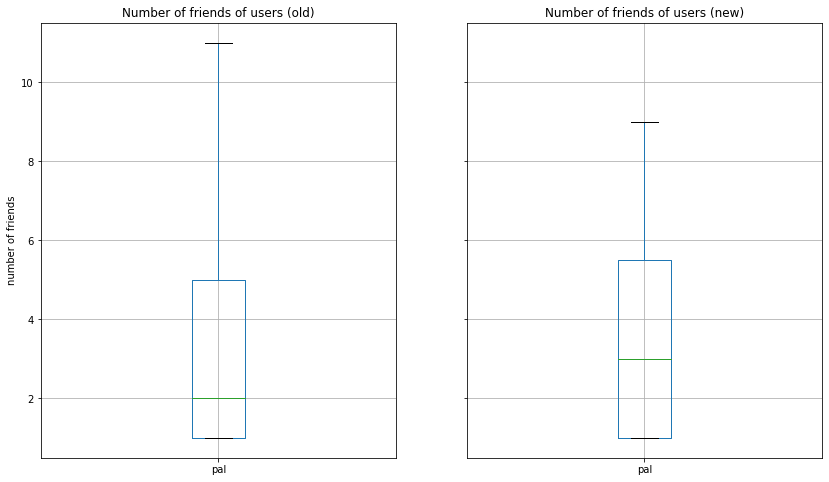

In [37]:
df_friend_old = pd.read_csv(raw_dataset_file.open('dataset_WWW2019/dataset_WWW_friendship_old.txt'), header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(1,2, figsize = (14, 8), sharey = True)
ax[0].set_title("Number of friends of users (old)")
ax[1].set_title("Number of friends of users (new)")
ax[0].set_ylabel("number of friends")
df_friend_old.groupby("friend").count().boxplot(ax = ax[0], column = ['pal'],showfliers=False)
df_friend.groupby("friend").count().boxplot(ax = ax[1], column = ['pal'],showfliers=False)

The results indicate us that most users don't have many friends on Foursquare. There are a few "super users" that have a lot of friends and they falsify our average values. If we want to find meaningful results, we should work on the quartiles. This structure of friendships is topical of social networks.<br>
We notice that the number seems to have grown over time, but not by a lot.

### Step 5 : Behaving like natives <a id='Step_5'></a>

#### Substep 1 : Combinations of checkins
---
Now that we have an idea of how sociable natives are, we need to identify how they behave. In order to do so, we must identify the places they go to, at what frequency, and what combinations of places they go on the same day.<br>
The graph below gives us some information on activities that natives do, but we don't know much about the context. Imagine for example that everybody goes shopping on the week-end : what a major "faux-pas" it would be to go on weekdays after work ! What if you want to hang out ? What combination of activities should you choose ? So many questions...

In [9]:
# We start by creating a column indicating the day of the checkin

df_US_natives["day_of_check_in"] = df_US_natives["time_checkin"].apply(lambda x : x[:10])

# We start by looking at how many checkins each user does daily. From this, we extract the list of users and 
# that checked-in more than once per day and the dataframe of their checkins.
multi_day_dataset = df_US_natives.groupby(["person_id", "day_of_check_in"]).agg("count").sort_values(by = "zone_id", ascending = False)
list_of_multi_day = multi_day_dataset[multi_day_dataset["zone_id"]>1].index.to_list()
dataframe_multi_day = df_US_natives.set_index(["person_id", "day_of_check_in"]).loc[list_of_multi_day].drop(columns = ["year", "zone_id","Lat", "lon", "country"])

In [10]:
# A first interesting observation is that most checkins come from people that checked more than once per day.
dataframe_multi_day.shape[0]/df_US_natives.shape[0]

0.5500185602343166

In [11]:
dataframe_multi_day

time_checkin        building
person_id day_of_check_in                                           
347405    2013-01-12       2013-01-12 05:49:08+00:00      University
          2013-01-12       2013-01-12 07:40:27+00:00      University
          2013-01-12       2013-01-12 08:17:48+00:00      University
          2013-01-12       2013-01-12 09:25:48+00:00  Student Center
          2013-01-12       2013-01-12 09:26:03+00:00  Student Center
...                                              ...             ...
413005    2013-03-24       2013-03-24 16:32:05+00:00           Diner
98454     2013-01-18       2013-01-18 01:40:15+00:00             Bar
          2013-01-18       2013-01-18 14:34:21+00:00        Hospital
102862    2013-02-19       2013-02-19 13:50:52+00:00          School
          2013-02-19       2013-02-19 20:54:08+00:00          School

[648990 rows x 2 columns]

In [14]:
# There are some people who check multiple times a day to the same place. We interpret this as them checking-in 
# On their workplace or at their home. This does not interest us. As a result, we eliminate users who check-in
# only at the same place.

count_nb_checkin_per_day = dataframe_multi_day.groupby(by = ["person_id", "day_of_check_in", "building"]).agg("count").reset_index()
inter = count_nb_checkin_per_day.groupby(by = ["person_id", "day_of_check_in"]).agg("count")
inter_list = inter[inter["building"]>1].index.to_list()
people_who_checked_at_multiple_places = count_nb_checkin_per_day.set_index(["person_id", "day_of_check_in"]).loc[inter_list].reset_index()
merged_db = people_who_checked_at_multiple_places.merge(people_who_checked_at_multiple_places, on = ["person_id", "day_of_check_in"])
merged_db = merged_db[merged_db["building_x"] != merged_db["building_y"]].drop(columns = ["time_checkin_x"])

# We now put on a label indicating the two activities that are done at the same time. The label is : 
# (activity_1, activity_2). Since (activity_1, activity_2) = (activity_2, activity_1), we have each row repeated 
# twice. We will take care of this later.
inter = pd.DataFrame()
inter["first_building"] = merged_db["building_x"]
inter["second_building"] = merged_db["building_y"]
inter_list = inter.values.tolist()
merged_db["label"] = [tuple(sorted(list(val))) for val in inter_list]

merged_db

,person_id,day_of_check_in,building_x,building_y,time_checkin_y,label
1,19,2013-01-05,Airport,Tech Startup,1,"(Airport, Tech Startup)"
2,19,2013-01-05,Tech Startup,Airport,1,"(Airport, Tech Startup)"
5,19,2013-01-09,Coffee Shop,University,1,"(Coffee Shop, University)"
6,19,2013-01-09,University,Coffee Shop,1,"(Coffee Shop, University)"
9,19,2013-01-11,Bar,Italian Restaurant,1,"(Bar, Italian Restaurant)"
...,...,...,...,...,...,...
1876122,2181131,2013-04-24,Residential Building (Apartment / Condo),Home (private),1,"(Home (private), Residential Building (Apartme..."
1876125,2181131,2013-04-25,Building,Residential Building (Apartment / Condo),1,"(Building, Residential Building (Apartment / C..."
1876126,2181131,2013-04-25,Residential Building (Apartment / Condo),Building,1,"(Building, Residential Building (Apartment / C..."
1876129,2181131,2013-04-29,Building,Home (private),1,"(Building, Home (private))"


In [15]:
# Now, we want to evaluate the occurence of each label, we also divide our values by 2 in order to compensate
# the fact that (activity_1, activity_2) = (activity_2, activity_1)
db_ordered_by_labels = merged_db.groupby("label").agg("count").sort_values(by = "person_id", ascending = False).drop(columns = ["day_of_check_in","building_x", "building_y", "time_checkin_y" ])
db_ordered_by_labels["person_id"] = db_ordered_by_labels["person_id"]/2

<BarContainer object of 20 artists>

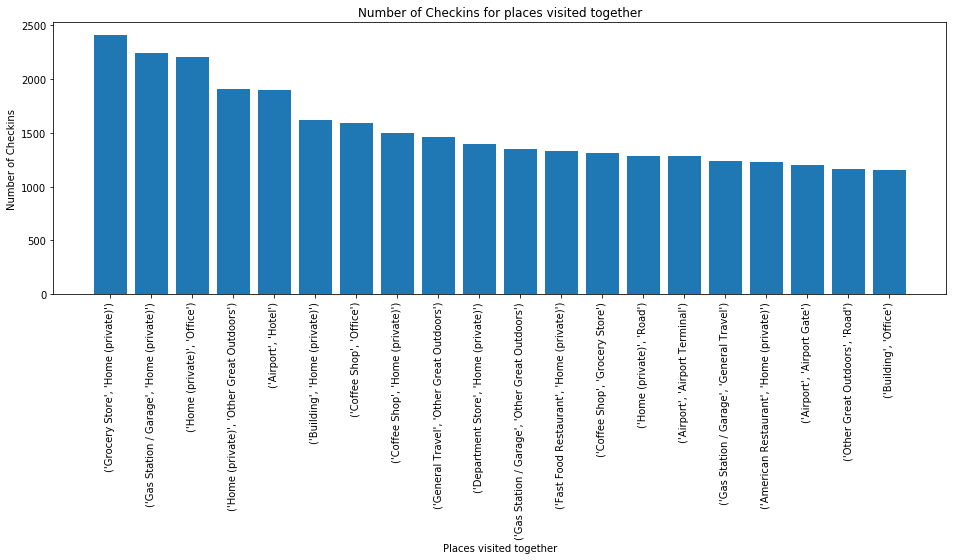

In [16]:
fig, ax = plt.subplots(figsize=(16,5))

plt.title('Number of Checkins for places visited together')
plt.ylabel('Number of Checkins')
plt.xlabel('Places visited together')
plt.xticks(rotation=90)

my_index = [str(element) for element in db_ordered_by_labels.head(20).index]
my_values = [element[0] for element in db_ordered_by_labels.head(20).values]
plt.bar(my_index, my_values)

#### Partial conclusion
When we look at the places visited together, we notice that there are a lot of them that are of the form (Place, Home (private)) This comes from the fact that, as we have seen before, Home (private) is the most popular chackin place for our population. We notice that among our popular combinations, we have some that can be explained both intuitively and culturally. For example, the combination (Coffee Shop, Office) has already been mentionned earlier. While the combination, (Airport, Hotel) can be explained intuitively as "when we come from the airport, we have to find a hotel to stay". However, the fact that it is the fifth most popular combination can only be explained as "In the US, since the country is so large, it is much more common to travel by plane".

In [17]:
#We now sum up everything that we have done as a python function. 
#In order to check that our functions translate to other datasets, we check our results with the dataset of japanese logins.

def get_combination_natives(df_natives, poi_interest = False):
    # We then create a column giving the day of checkins
    df_natives["day_of_check_in"] = df_natives["time_checkin"].apply(lambda x : x[:10])
    
    # We now extract the dataframe of all the users that made multiple checkins per day.
    inter = df_natives.groupby(["person_id", "day_of_check_in"]).agg("count").sort_values(by = "zone_id", ascending = False)
    list_of_multi_day = inter[inter["zone_id"]>1].index.to_list()
    dataframe_multi_day = df_natives.set_index(["person_id", "day_of_check_in"]).loc[list_of_multi_day].drop(columns = ["year", "zone_id","Lat", "lon", "country"])
    
    # The next step is surpressing all the check-ins from people who check-in from the same place in order to focus on
    # only on people who visit multiple places on the same day.
    count_nb_checkin_per_day = dataframe_multi_day.groupby(by = ["person_id", "day_of_check_in", "building"]).agg("count").reset_index()
    inter = count_nb_checkin_per_day.groupby(by = ["person_id", "day_of_check_in"]).agg("count")
    inter_list = inter[inter["building"]>1].index.to_list()
    people_who_checked_at_multiple_places = count_nb_checkin_per_day.set_index(["person_id", "day_of_check_in"]).loc[inter_list].reset_index()
    merged_db = people_who_checked_at_multiple_places.merge(people_who_checked_at_multiple_places, on = ["person_id", "day_of_check_in"])
    merged_db = merged_db[merged_db["building_x"] != merged_db["building_y"]].drop(columns = ["time_checkin_x"])
    
    # We now put on a label indicating the two activities that are done at the same time. The label is : 
    # (activity_1, activity_2). Since (activity_1, activity_2) = (activity_2, activity_1), we have each row repeated 
    # twice. We will take care of this later.
    inter = pd.DataFrame()
    inter["first_building"] = merged_db["building_x"]
    inter["second_building"] = merged_db["building_y"]
    inter_list = inter.values.tolist()
    merged_db["label"] = [tuple(sorted(list(val))) for val in inter_list]
    
    # If we give a value for "poi_interest", we return not only the dataframe of combinations, but also the number
    # of times users check-ed at the place "poi_interest"
    if poi_interest:
        return(merged_db, sum(people_who_checked_at_multiple_places.set_index("building").loc[poi_interest]["time_checkin"]))
    
    return(merged_db)

In [18]:
df_JP = pd.read_csv(data_file.open('data/6_JP_2013_merge_data.csv'))
natives_JP = get_natives(df_JP)
combination_df_JP = get_combination_natives(natives_JP)
db_ordered_by_labels = combination_df_JP.groupby("label").agg("count").sort_values(by = "person_id", ascending = False).drop(columns = ["day_of_check_in","building_x", "building_y", "time_checkin_y" ])
db_ordered_by_labels["person_id"] = db_ordered_by_labels["person_id"]/2

<BarContainer object of 20 artists>

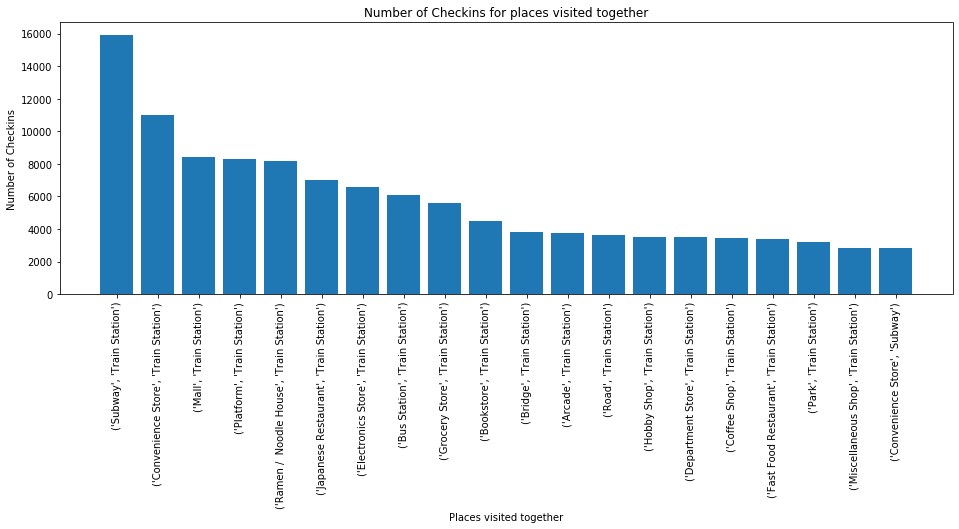

In [19]:
fig, ax = plt.subplots(figsize=(16,5))

plt.title('Number of Checkins for places visited together')
plt.ylabel('Number of Checkins')
plt.xlabel('Places visited together')
plt.xticks(rotation=90)

my_index = [str(element) for element in db_ordered_by_labels.head(20).index]
my_values = [element[0] for element in db_ordered_by_labels.head(20).values]
plt.bar(my_index, my_values)

Due to the over-representation of "Train Station" in our checkins, it becomes difficult to infer meaningful information from the combinations of checkins. What we can guess is that Japanese people use the public transport a lot, both for work and leisure purposes.

#### Substep 2 : Predicting movements
---
During the last two parts, we observed what users did in order to understand their behaviours. We noticed and studied cultural specificities. We now want to compute predictive probabilities. We will try to answer the following questions :<br>
- What is the probability that a user checks-in multiple times a day?
- If a user checks-in multiple times, what is the probability that he checks-in from the same POI (given the POI)?
- If a user checks-in multiple times, what is the probability that he checks-in from different POIs, and which POIs is he most likely to check-in from (given the first place)? In our model, we will only study the case where we study the previous check-in. (More complicated models can try to give predictions out of all the previous check-ins).

###### SubSubStep 1: The first Checkin
---
We think that it is interesting to separate our checkins as "first checkin of the day" and "not first checkin of the day" because 
1) People have habits. Some check their phone every morning, others on their way to work... It is usually the same POI. When people checkin only once a day, we can still identify a POI from where they check-in most of the time.
2) If a person checks-in more than once a day, we can use our dataframe of couples of places to identify where the next check-in should be, based on the previous POI.

In [20]:
# First case : first check-in of the day. We start by computing the distributions for the first check-in of the day.
# In order to do so, we isolate the first check-in for every user and every day.

def get_distrib_first_checkin(df_natives):
    # We then create a column giving the day of checkins
    df_natives["day_of_check_in"] = df_natives["time_checkin"].apply(lambda x : x[:10])
    
    # We now extract the dataframe of all the first_checkins for a user.
    inter = df_natives.groupby(["person_id", "day_of_check_in"]).first().reset_index()
    popular_places_first_checkin = inter.groupby(["building"]).agg("count").sort_values(by = "zone_id", ascending = False)
    popular_places_first_checkin["my_stat"] = popular_places_first_checkin["person_id"] / sum(popular_places_first_checkin["person_id"]) * 100
    popular_places_first_checkin = popular_places_first_checkin.reset_index()
    return(popular_places_first_checkin[["building", "my_stat"]])

<BarContainer object of 20 artists>

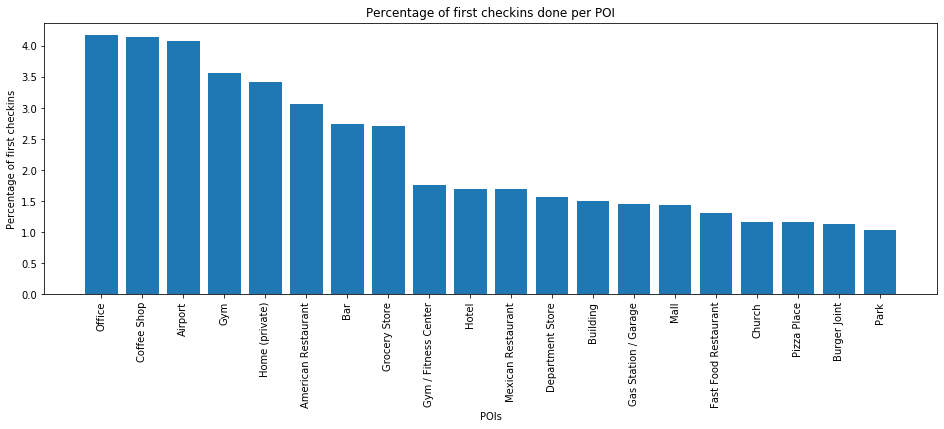

In [21]:
df_US = pd.read_csv(data_file.open('data/1_US_2013_merge_data.csv'))
US_natives = get_natives(df_US)
US_first_checkin = get_distrib_first_checkin(US_natives)
fig, ax = plt.subplots(figsize=(16,5))

plt.title('Percentage of first checkins done per POI')
plt.ylabel('Percentage of first checkins')
plt.xlabel('POIs')
plt.xticks(rotation=90)

my_index = [element for element in US_first_checkin.head(20).building]
my_values = [element for element in US_first_checkin.head(20).my_stat]
plt.bar(my_index, my_values)

#### Interpretation :
While "Home (private)" is the place with the most checkins in our US dataframe, we notice that users from the US usually don't check-in directly after waking up from their home. If users check-in mostly from their home, they do it after work.

<BarContainer object of 20 artists>

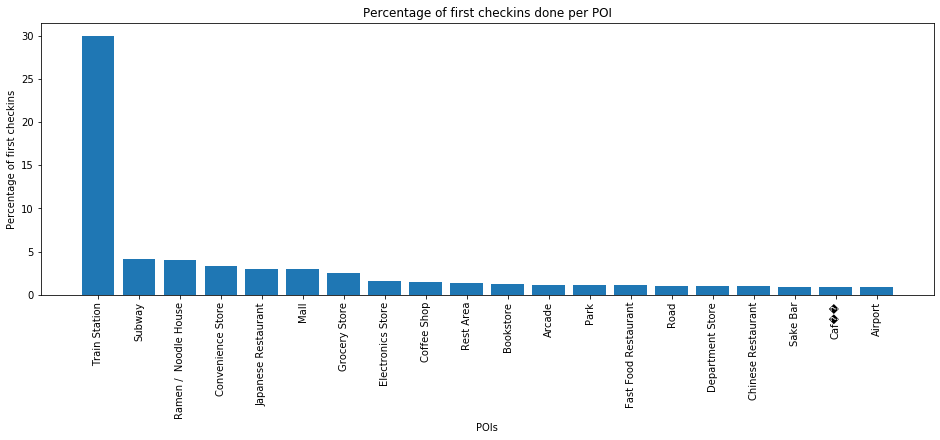

In [22]:
df_JP = pd.read_csv(data_file.open('data/6_JP_2013_merge_data.csv'))
natives_JP = get_natives(df_JP)
JP_first_checkin = get_distrib_first_checkin(natives_JP)

fig, ax = plt.subplots(figsize=(16,5))

plt.title('Percentage of first checkins done per POI')
plt.ylabel('Percentage of first checkins')
plt.xlabel('POIs')
plt.xticks(rotation=90)

my_index = [element for element in JP_first_checkin.head(20).building]
my_values = [element for element in JP_first_checkin.head(20).my_stat]
plt.bar(my_index, my_values)

#### Interpretation :
After what we have seen on Japan, we expected results like these : threre is a very high probability that users check-in while at the train station. other results are crushed in comparaison.

###### SubSubstep 2 : The second checkin and above
---
We now want to study all checkins that took place after the first check-in. In order to do so, we create a function that, given the POI received at the first checkin, gives the probability for our second check-in.

In [23]:
# We have already a function that, given a dataframe, retrieves the combinations of (POI 1, POI 2). We now create a
# function that returns the number of times where users have checked-in at the same place.

def get_check_same_place(df_natives):
    # We first create a column giving the day of checkins
    df_natives["day_of_check_in"] = df_natives["time_checkin"].apply(lambda x : x[:10])
    
    # We start by retrieving the users that checked more than once on the same day.
    inter = df_natives.groupby(["person_id", "day_of_check_in"]).agg("count").sort_values(by = "zone_id", ascending = False)
    list_of_multi_day = inter[inter["zone_id"]>1].index.to_list()
    dataframe_multi_day = df_natives.set_index(["person_id", "day_of_check_in"]).loc[list_of_multi_day].drop(columns = ["year", "zone_id","Lat", "lon", "country"])
    
    # There are two possible cases : either the user stays at the same POI or he moves to the different POI
    # In order to find what we want, we extract the datasets of all users that checked more than once at the same
    # place on the same day.
    count_nb_checkin_per_day = dataframe_multi_day.groupby(by = ["person_id", "day_of_check_in", "building"]).agg("count")
    dataset_check_same_place = count_nb_checkin_per_day[count_nb_checkin_per_day["time_checkin"]>1].reset_index().drop(columns = {"person_id", "day_of_check_in"})
    #### We want to not take into account the first checkin for all the places where we check-in multiple times
    # As a result, we substract 1 from our counts to remove the first checkin
    dataset_check_same_place["time_checkin"] = dataset_check_same_place["time_checkin"] - 1
    probability_dataset = dataset_check_same_place.groupby(by = ["building"]).agg("count")
    
    return(probability_dataset.sort_values(by = "time_checkin",ascending = False))

In [24]:
get_check_same_place(US_natives)

,time_checkin
building,
Airport,5469
Home (private),5143
Road,2049
Office,1708
Other Great Outdoors,1577
...,...
Paella Restaurant,1
College & University,1
Storage Facility,1


In [25]:
# The following function returns for a given dataframe, and a given POI the probability that :
# - The user doesn't check-in another time in the day
# - The user checks-in another time in the day from the same place
# - The user checks-in another time in the day from another place

# If we put info to True, the function will return the probability that we check to each POI given that we check-in
# another time in the day from another place.

def get_probability(df_natives,poi_first_checkin, info = False):
    # We first create a column giving the day of checkins
    df_natives["day_of_check_in"] = df_natives["time_checkin"].apply(lambda x : x[:10])
    
    # We start by retrieving the number of checkins for users that checked only once per day.
    inter = df_natives.groupby(["person_id", "day_of_check_in"]).agg("count").sort_values(by = "zone_id", ascending = False)
    list_single_day = inter[inter["zone_id"]==1].index.to_list()
    dataframe_single = df_natives.set_index(["person_id", "day_of_check_in"]).loc[list_single_day].drop(columns = ["year", "zone_id","Lat", "lon", "country"]).reset_index()
    dataframe_single = dataframe_single.groupby(by = "building").agg("count").sort_values(by = "time_checkin",ascending = False)
    number_no_other_checkin = dataframe_single.loc[poi_first_checkin]["time_checkin"]
    
    # We then retrieve the number of checkins for users that checked-in more than once at the same place on the
    # same day.
    dataframe_twice_same = get_check_same_place(df_natives)
    number_check_same_place = dataframe_twice_same.loc[poi_first_checkin]["time_checkin"]
    
    # We finally extract the number of combinations featuring the POI "poi_first_checkin"
    dataframe_combination, number_different_place = get_combination_natives(df_natives, poi_first_checkin)
    
    # We compute our probabilities
    probability_no_other_checkin = number_no_other_checkin/(number_no_other_checkin+number_check_same_place+number_different_place)
    probability_check_same_place = number_check_same_place/(number_no_other_checkin+number_check_same_place+number_different_place)
    probability_different_place = number_different_place/(number_no_other_checkin+number_check_same_place+number_different_place)
    
    if info:
        # If we put info to True, the function will return the probability that we check to each POI given 
        # that we check-in another time in the day from another place.
        dataframe_combination["is_in_label"] = dataframe_combination["label"].apply(lambda x : True if poi_first_checkin in x else False )
        dataframe_combination = dataframe_combination[dataframe_combination["is_in_label"]].drop(columns = {"day_of_check_in","building_x","building_y","time_checkin_y"})
        dataframe_combination = dataframe_combination.groupby("label").agg("count").reset_index()
        dataframe_combination["person_id"] = dataframe_combination["person_id"]/sum(dataframe_combination["person_id"])
        dataframe_combination = dataframe_combination.drop(columns = {"is_in_label"}).set_index("label").sort_values(by = "person_id", ascending = False)
        return(probability_no_other_checkin, probability_check_same_place, probability_different_place, dataframe_combination)
    
    return(probability_no_other_checkin, probability_check_same_place, probability_different_place)

In [26]:
get_probability(US_natives, "Office", True)

(0.5421903052064632,
 0.036505086774386596,
 0.4213046080191502,
                                   person_id
 label                                      
 (Home (private), Office)           0.061985
 (Coffee Shop, Office)              0.044878
 (Building, Office)                 0.032610
 (Gas Station / Garage, Office)     0.028812
 (Gym, Office)                      0.028502
 ...                                     ...
 (Afghan Restaurant, Office)        0.000028
 (Credit Union, Office)             0.000028
 (Boarding House, Office)           0.000028
 (Conference, Office)               0.000028
 (Gluten-free Restaurant, Office)   0.000028
 
 [403 rows x 1 columns])

### Conclusion :
---
We now have all the tools we need to understand native people from foreign countries : we know what are their behaviours toward friends, how sociable they are, where they like to hang out and what are the proability that they go to which POIs. <br>
All that is left now is to travel !